This code shows the effect of a simple delay filter compared to low pass filter when the frequency of periodic noise is known.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.fft import fft, fftfreq, ifft
import pandas as pd
import os


In [2]:
fn = os.path.join('..', 'data', 'BP_data.pkl')
df = pd.read_pickle(fn)
print(df.head())

  SubjectID Condition  Age Gender  Height  Weight  SystolicP  DiastolicP  \
0  c010510d        BN   63      M   170.0    66.1      161.0        82.5   
1  c010510d        BN   63      M   170.0    66.1      162.2        82.8   
2  c010510d        AN   63      M   170.0    66.1      155.2        80.3   
3  c010510d        AN   63      M   170.0    66.1      157.3        79.3   
4  c010610d        BN   49      M   175.2    82.4      129.5        72.6   

   MeanP                                              CuffP  \
0  113.5  [78.0799, 79.37099, 80.66207, 81.95315, 83.244...   
1  113.4  [64.32275, 65.56285, 66.802956, 68.04306, 69.2...   
2  106.8  [63.112442, 64.64711, 66.181786, 67.71645, 69....   
3  106.9  [62.98758, 64.516235, 66.0449, 67.573555, 69.1...   
4   96.7  [68.72236, 69.447624, 70.17289, 70.89816, 71.6...   

                                           Amplitude  \
0  [3.8775666, 3.9830372, 4.088508, 4.206781, 4.3...   
1  [2.310238, 2.3567293, 2.4032207, 2.4376183, 2....

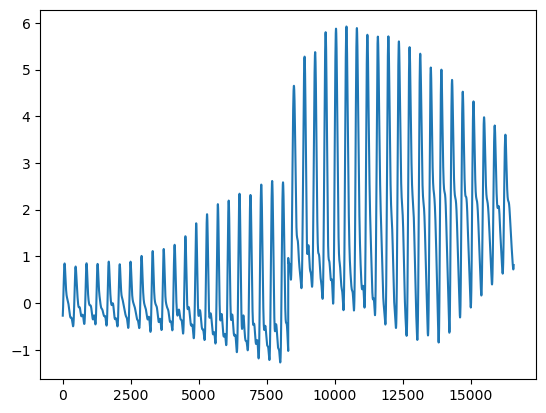

In [3]:
i = 0

t = np.linspace(0, 1, len(df.loc[i, 'dc_cuff_pressure']))

y_other = df.loc[i, 'dc_cuff_pressure'] * 0 + 2*np.heaviside(t-.5, 0)
y_measured = y_other + df.loc[i, 'cuff_pressure_oscillations']
plt.plot(y_measured)

Fundamental frequency: 0.002533783783783784 cycles/sample
394


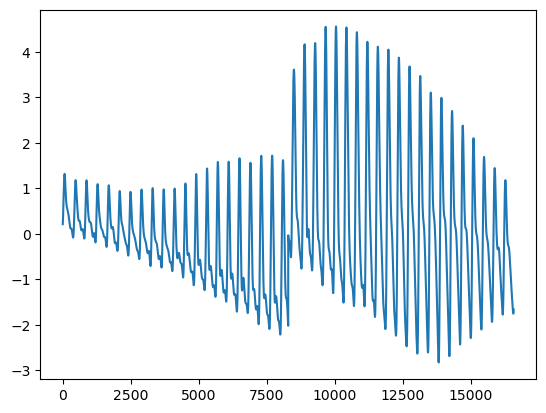

In [4]:
y = y_measured- np.mean(y_measured)
y = signal.detrend(y)
plt.plot(y)


fft_values = fft(y)
frequencies = fftfreq(len(y), d=1)
# Consider only positive frequencies
positive_frequency_indices = np.where(frequencies > 0)[0]
positive_frequencies = frequencies[positive_frequency_indices]
positive_fft_values = np.abs(fft_values[positive_frequency_indices])

# Find the index of the maximum value
peak_index = np.argmax(positive_fft_values)

# Get the fundamental frequency
fundamental_frequency = positive_frequencies[peak_index]

print(f"Fundamental frequency: {fundamental_frequency} cycles/sample")
delay_points = int(1/fundamental_frequency)
print(delay_points)

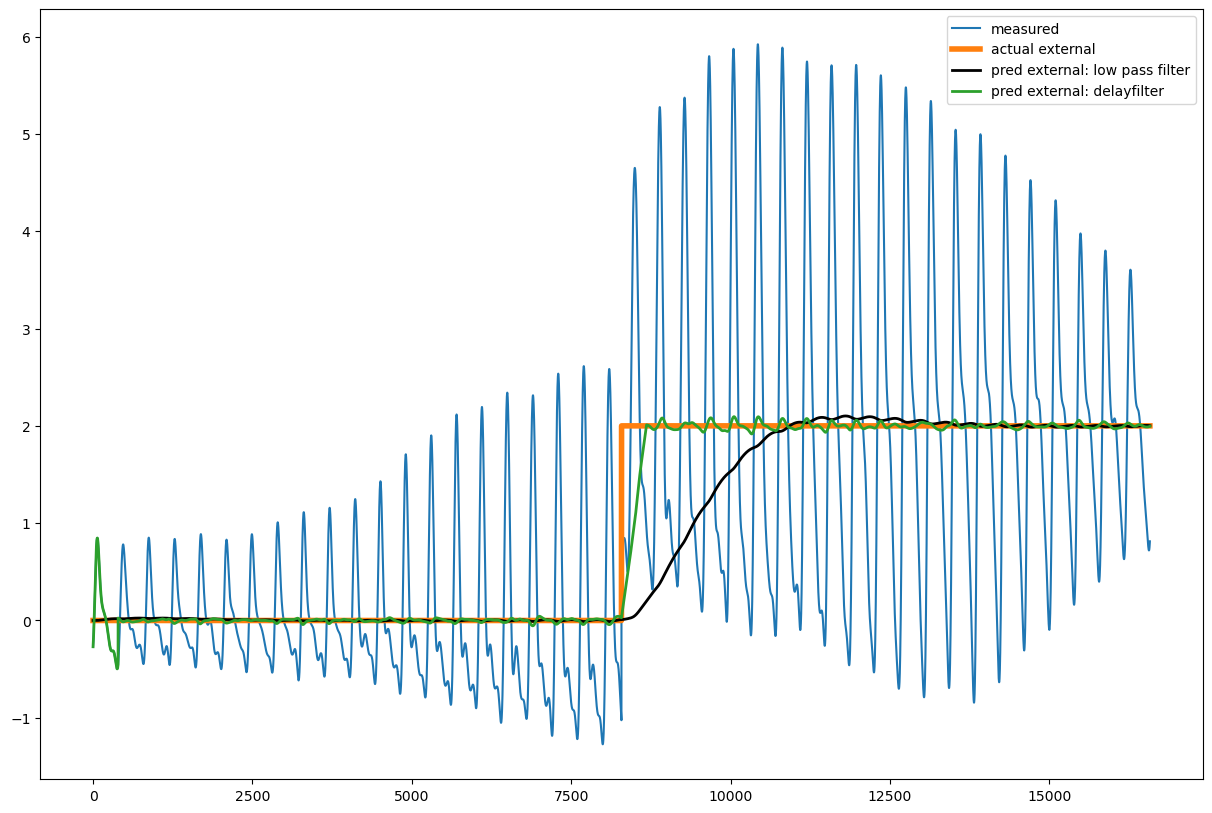

In [5]:

def method_filter(y_measured, wn): # low pass filter

    sos = signal.butter(2, wn, 'lp', fs=1, output='sos')  # 2nd order lowpass filter
    y_filtered = signal.sosfilt(sos, y_measured)

    return y_filtered


def method_filter_delayed(y_measured, delay): # delay filter

    #y_recovered = np.zeros_like(y_measured)
    y_recovered = y_measured.copy()
    y_recovered[delay-1]= np.mean(y_recovered[:delay]) # start assuming the mean

    for i in range(delay, len(y_measured)):
        dy = y_measured[i]-y_measured[i-delay]  # the sginal has changed this much in 1 period
        y_recovered[i] = y_recovered[i-1] + dy/delay  # integrate
        
    return y_recovered  # note - in a real signal with noise, you may want to futher filter this


y_filtered1 = method_filter(y_measured, wn = .0002)
y_filtered2 = method_filter_delayed(y_measured, delay_points)

fig, ax = plt.subplots()
ax.plot(y_measured, label = 'measured')
ax.plot(y_other, label = 'actual external', linewidth = 4)

ax.plot(y_filtered1, label = 'pred external: low pass filter', linewidth = 2, c = 'k')
ax.plot(y_filtered2, label = 'pred external: delayfilter', linewidth = 2)

ax.legend()
fig.set_size_inches(15, 10)

In [6]:
# This code does not work yet

# y = np.sin(5*t) + 0.5*np.sin(2.5*t) + t
# yp = y.copy()
# from scipy.signal.windows import blackman



# def predict_next_point(y, fs):

#     ym = np.mean(y)
#     y = signal.detrend(y)

#     N = len(y)
#     #w = blackman(N)

#     T = 1/fs
#     yf = fft(y*1)
#     freqs = fftfreq(N, T)
#     yf2 = yf*np.exp(np.array([0+1j])*freqs*T)

#     #I = np.logical_and(np.abs(freqs) > 5,   np.abs(freqs) < 0)
#     #yf2[I]=0

#     yr2 = ifft(yf2)
#     return yr2[[-1]]

# plt.plot(t, y)

# for i in range(200):
#     yp = predict_next_point(y[-1000:], fs)
#     plt.plot(t[-1]+T*i, yp, 'x')
#     y = np.concatenate((y, yp))